# Question_3

# Outline

## Classical time series model 

- Missing value analysis
- Outlier analysis
- Split the dataset 
- Ad Fuler test
- Autocorrelation and partial autocorrelation
- Model selection and fitting best model
- Model diagnostics 
- Calculate RMSE and Actual Data vs Prediction visualization

## Machine Learning Model

- Splitting the data 
- Correlation analysis
- Feature creation
- Analyze Target feature relationship
- Creation of Machine learning model
    - Random Forest (RF)
        - Actual Vs predictions
        - Hyperparameter tuning 
    - XGBoost Model
        - Feature Importance
        - Forecasting 
        - Hyperparameter tuning
        - Forecasting After hyper-parameter tuning

# Classical Time Series Model 

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import itertools
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from pylab import rcParams

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

### Read the dataset

In [2]:
df = pd.read_csv("Sales Data.csv")

In [3]:
df.head()

,Date,Sales Quantity,Discount Percentage
0,2023-01-01,6934,0.050
1,2023-01-02,5187,0.010
2,2023-01-03,5004,0.012
3,2023-01-04,5155,0.013
4,2023-01-05,4785,0.011


In [4]:
df.shape

(100, 3)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 100 non-null    object 
 1   Sales Quantity       100 non-null    int64  
 2   Discount Percentage  100 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.5+ KB


In [6]:
df.describe()

,Sales Quantity,Discount Percentage
count,100.000000,100.000000
mean,5762.410000,0.017426
std,1200.232243,0.006937
min,3196.000000,0.010000
25%,4967.250000,0.014000
50%,5672.500000,0.015600
75%,6396.250000,0.020000
max,9918.000000,0.050000


### Missing values Analysis

In [7]:
#check the null values in the data set
df.isnull().sum()

Date                   0
Sales Quantity         0
Discount Percentage    0
dtype: int64

##### There are no any missing values in the data set.

### Outlier Analysis

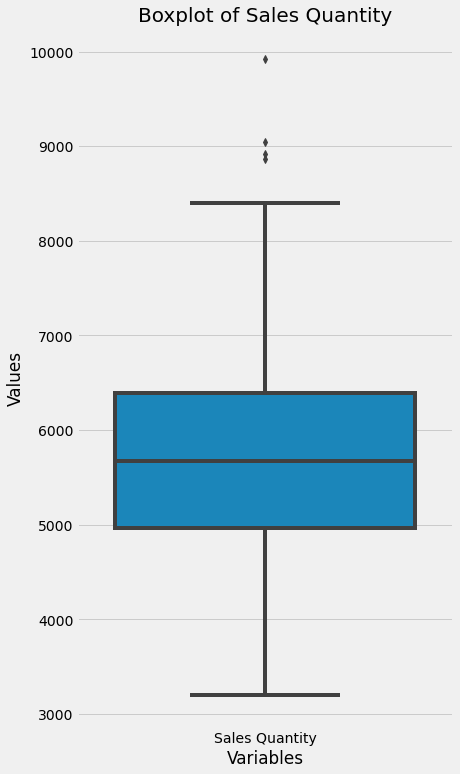

In [8]:
plt.style.use('fivethirtyeight') 

plt.figure(figsize=(6, 12))
sns.boxplot(data=df[['Sales Quantity']])
plt.title('Boxplot of Sales Quantity', fontsize = 20)
plt.xlabel('Variables')
plt.ylabel('Values')
plt.show()

##### We can see that there are some outliers exist in the Sales quantity. 

##### Identify the outliers and replace outliers the with nearest non-outlier value

In [9]:
#identify the outliers using Z score
mean_sales = np.mean(df['Sales Quantity'])
std_sales = np.std(df['Sales Quantity'])

# Define a threshold for outliers
threshold = 3

# Calculate z-scores
z_scores = (df['Sales Quantity'] - mean_sales) / std_sales

outliers = df[np.abs(z_scores) > threshold]

print("Mean:", mean_sales)
print("Standard Deviation:", std_sales)
print("Threshold for Outliers (3 standard deviations from the mean):", threshold)
print("Outliers:")
print(outliers)

Mean: 5762.41
Standard Deviation: 1194.2160030329524
Threshold for Outliers (3 standard deviations from the mean): 3
Outliers:
          Date  Sales Quantity  Discount Percentage
91  2023-04-02            9918                0.045


##### Here we can observe that there is an outlier in the date '2023-04-02'. 

In [10]:
#Replace the outliers with nearest non-outlier value
outliers_index = np.abs(z_scores) > threshold

for i, outlier_index in enumerate(outliers_index):
    if outlier_index:
        nearest_non_outlier_index = np.argmin(np.abs(z_scores[:i] - z_scores[i]))
        # Replace outlier with nearest non-outlier data point
        df.at[i, 'Sales Quantity'] = df.at[nearest_non_outlier_index, 'Sales Quantity']

#### Boxplots for the data after outlier treatment

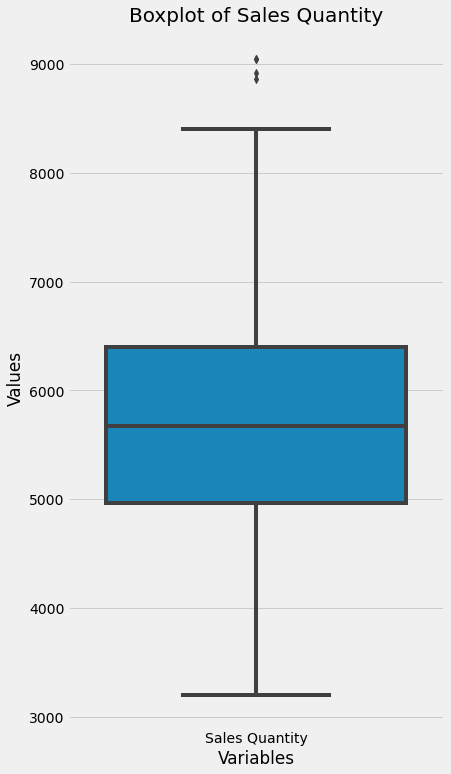

In [11]:
plt.figure(figsize=(6, 12))
sns.boxplot(data=df[['Sales Quantity']])
plt.title('Boxplot of Sales Quantity', fontsize = 20)
plt.xlabel('Variables')
plt.ylabel('Values')
plt.show()

### Set the 'Date' column as the index of the dataset

In [12]:
#set the 'Data' column 
df['Date'] = pd.to_datetime(df['Date'])  

In [13]:
#set 'Date' column as indes
df.set_index('Date', inplace = True)
df.head()

,Sales Quantity,Discount Percentage
Date,,
2023-01-01,6934,0.050
2023-01-02,5187,0.010
2023-01-03,5004,0.012
2023-01-04,5155,0.013
2023-01-05,4785,0.011


In [14]:
#dropping column 'Discount Percentage'
df_cl = df.drop(['Discount Percentage'], axis = 1)

### Sales quantity

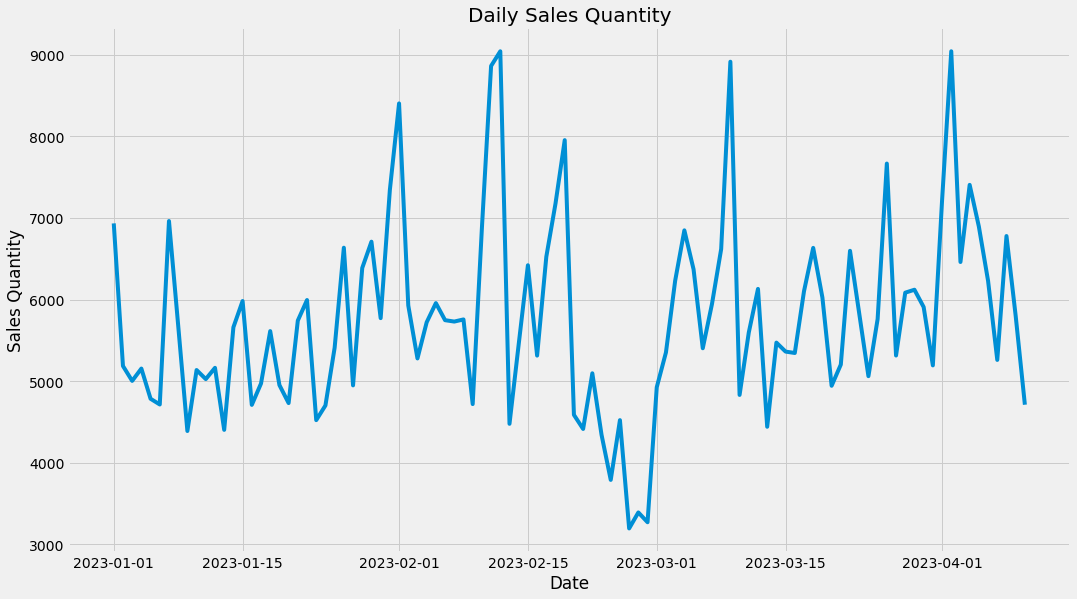

In [15]:
plt.figure(figsize=(16,9))
plt.plot(df_cl['Sales Quantity'])
plt.title('Daily Sales Quantity', fontsize = 20)
plt.xlabel('Date')
plt.ylabel('Sales Quantity')
plt.show()


###### Analysing the chart we can conclude that, the Sales Quantity is spread around the mean 5762 and the data do not significantly deviate from the mean of  the Sales quantity. We cannot clearly see the trend pattern in the Sales, and also there is no significant variation in the Sales Quantity. However we can observe that the time series has seasonality pattern.

### Split the data set

In [16]:
train_ind = int(len(df_cl) * 0.90)
y_train = df_cl[:train_ind]
y_test = df_cl[train_ind:]

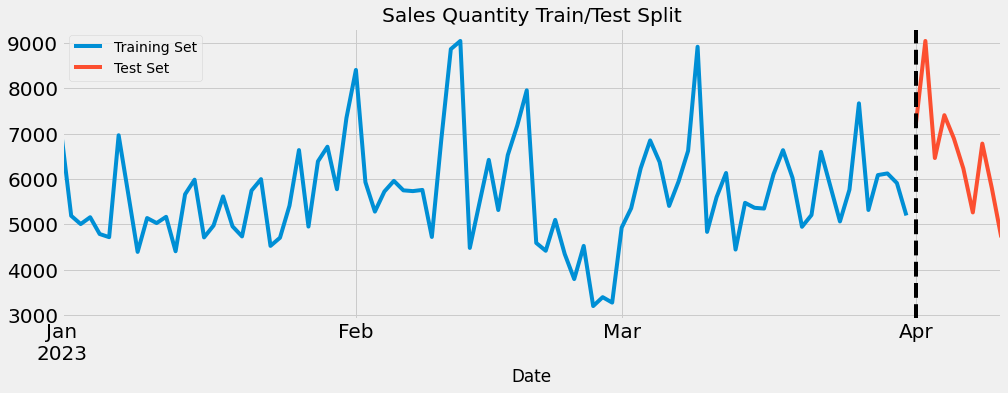

In [17]:
fig, ax = plt.subplots(figsize=(15, 5))
y_train.plot(ax=ax, label='Training Set', title='Sales Quantity Train/Test Split', fontsize = 20)
y_test.plot(ax=ax, label='Test Set')
ax.axvline('2023-04-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

### Ad Fuller test to check the stationarity of the data

In [18]:
result = adfuller(y_train)

print('ADF Statistics : %f' % result[0])
print('p-value for sales quantity : %f'% result[1])
print("Critical values : ")

for key, value in result[4].items():
    print('\t % s : % 3f' % (key, value))

ADF Statistics : -6.224851
p-value for sales quantity : 0.000000
Critical values : 
	 1% : -3.506057
	 5% : -2.894607
	 10% : -2.584410


##### According to the Ad Fuller test the p-value for sales quantity is 0.000000 < 0.05. Therefore there is no stationarity in the data.

### Autocorrelation and Partial Autocorrelation

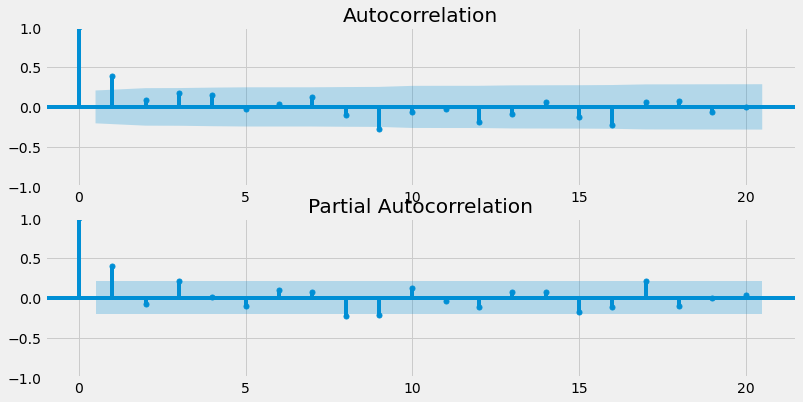

In [19]:
fig, ax = plt.subplots(2, figsize = (12, 6))
ax[0] = plot_acf(y_train, ax = ax[0], lags = 20)
ax[1] = plot_pacf(y_train, ax = ax[1], lags = 20)

##### ACF plots show the correlation between a time series and a lagged version of itself. According to the ACF plot we can observe a significant peek in the 9th lag value after the first significant peek value.

##### PACF plots show the correlation between a time series and a lagged version of itself after removing the effects of intervening observations. 

### Time series decomposition to see trend, seasonality and residuals

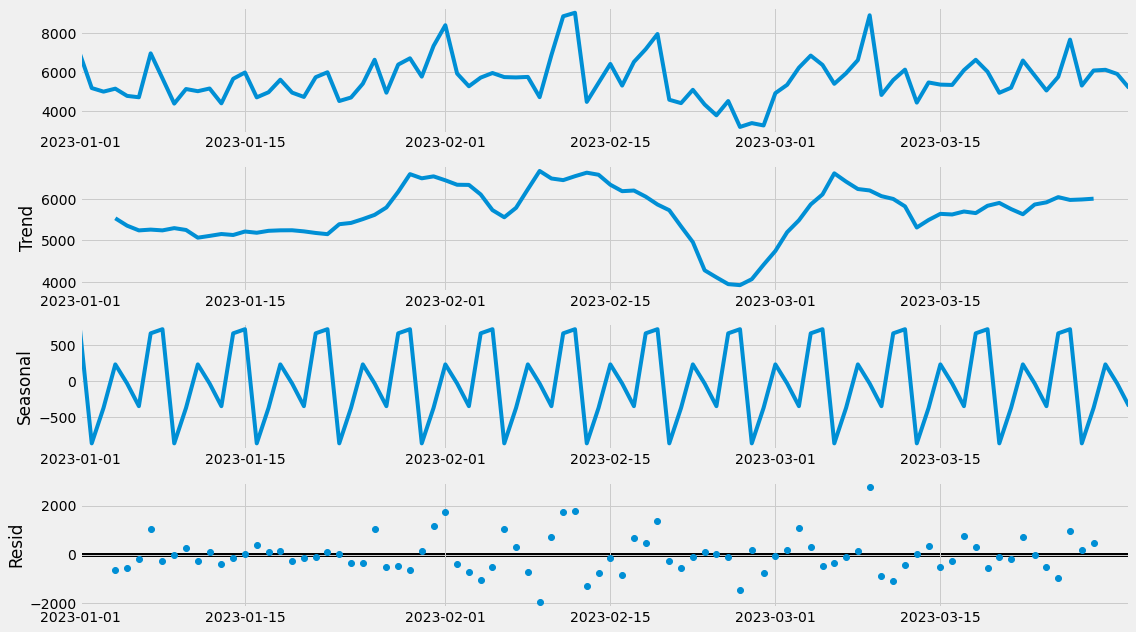

In [20]:
rcParams['figure.figsize'] = 16, 9
decomposition = sm.tsa.seasonal_decompose(y_train, model = 'additive')
fig = decomposition.plot()
plt.show()

##### According to the decompose plot we cannot observe clear trend pattern in the data. During the month of the January, the salse remains relatively constatnt and then, increase towards the end of January.  After that the salse quantity variates and the by the end of February, the sales quantity have significantly decreased and then increased gradually.

##### According to the decompose plot we can observe that there is a strong seasonality in the data.

##### Since we can see seasonality in the data use Seasonal ARIMA model

##### Seasonal ARIMA has seven parameters, 3 for ARIMA and 4 for seasonal component.


### Model selection

In [21]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 9) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 9)
SARIMAX: (0, 0, 1) x (0, 1, 0, 9)
SARIMAX: (0, 1, 0) x (0, 1, 1, 9)
SARIMAX: (0, 1, 0) x (1, 0, 0, 9)


In [22]:
metric_aic_dict = dict()

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order = param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)
            model_aic = mod.fit()
            print('ARIMA{}x{}9 - AIC:{}'.format(param,param_seasonal,model_aic.aic))
            metric_aic_dict.update({(param, param_seasonal) : model_aic.aic})
        except Exception as e: 
            print("Exception:", e)
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 9)9 - AIC:1795.803268559372
ARIMA(0, 0, 0)x(0, 0, 1, 9)9 - AIC:1576.5615190421995
ARIMA(0, 0, 0)x(0, 1, 0, 9)9 - AIC:1434.440369850889
ARIMA(0, 0, 0)x(0, 1, 1, 9)9 - AIC:1250.9145982680852
ARIMA(0, 0, 0)x(1, 0, 0, 9)9 - AIC:1452.7333727130201
ARIMA(0, 0, 0)x(1, 0, 1, 9)9 - AIC:1415.4496973269154
ARIMA(0, 0, 0)x(1, 1, 0, 9)9 - AIC:1259.807428602706
ARIMA(0, 0, 0)x(1, 1, 1, 9)9 - AIC:1241.1767648420093
ARIMA(0, 0, 1)x(0, 0, 0, 9)9 - AIC:1684.0735350334198
ARIMA(0, 0, 1)x(0, 0, 1, 9)9 - AIC:1473.7125656228457
ARIMA(0, 0, 1)x(0, 1, 0, 9)9 - AIC:1402.797801672297
ARIMA(0, 0, 1)x(0, 1, 1, 9)9 - AIC:1215.269372879051
ARIMA(0, 0, 1)x(1, 0, 0, 9)9 - AIC:1437.5559502351427
ARIMA(0, 0, 1)x(1, 0, 1, 9)9 - AIC:1379.4040696814066
ARIMA(0, 0, 1)x(1, 1, 0, 9)9 - AIC:1249.8658122247978
ARIMA(0, 0, 1)x(1, 1, 1, 9)9 - AIC:1210.0831148185564
ARIMA(0, 1, 0)x(0, 0, 0, 9)9 - AIC:1505.7572022501317
ARIMA(0, 1, 0)x(0, 0, 1, 9)9 - AIC:1347.5744483397427
ARIMA(0, 1, 0)x(0, 1, 0, 9)9 - AI

##### The Akaike Information Criterion (AIC) is a measure used for model selection, particularly in the context of time series analysis with SARIMAX models. It balances the goodness of fit of the model with its complexity, penalizing models that have more parameters.



##### Here I noticed the lowest AIC values for the ARIMA(1, 1, 1)x(1, 1, 1, 9)9. 

### Fitting the final model as per the lowest aic

In [23]:
mod = sm.tsa.statespace.SARIMAX(y_train,
                                order = (1, 1, 1),
                                seasonal_order = (1, 1, 1, 9),
                                enforce_stationarity = False,
                                enforce_invertibility = False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3269      0.154      2.128      0.033       0.026       0.628
ma.L1         -0.8475      0.094     -9.061      0.000      -1.031      -0.664
ar.S.L9       -0.4237      0.125     -3.394      0.001      -0.668      -0.179
ma.S.L9       -0.8422      0.163     -5.153      0.000      -1.162      -0.522
sigma2      1.184e+06   2.53e+05      4.676      0.000    6.88e+05    1.68e+06


##### The non-seasonal AR term at lag 1 and the seasonal AR term at lag 9 both have negative coefficients, indicating negative relationships between the series at those lags and its subsequent values.


##### The non-seasonal MA term at lag 1 and the seasonal MA term at lag 9 both have negative coefficients, indicating negative relationships between the error term and its values at those lags.



##### All coefficients are statistically significant with p-values less than 0.05, suggesting that they are unlikely to be zero.

### Model Diagnostic plot to check the residuals

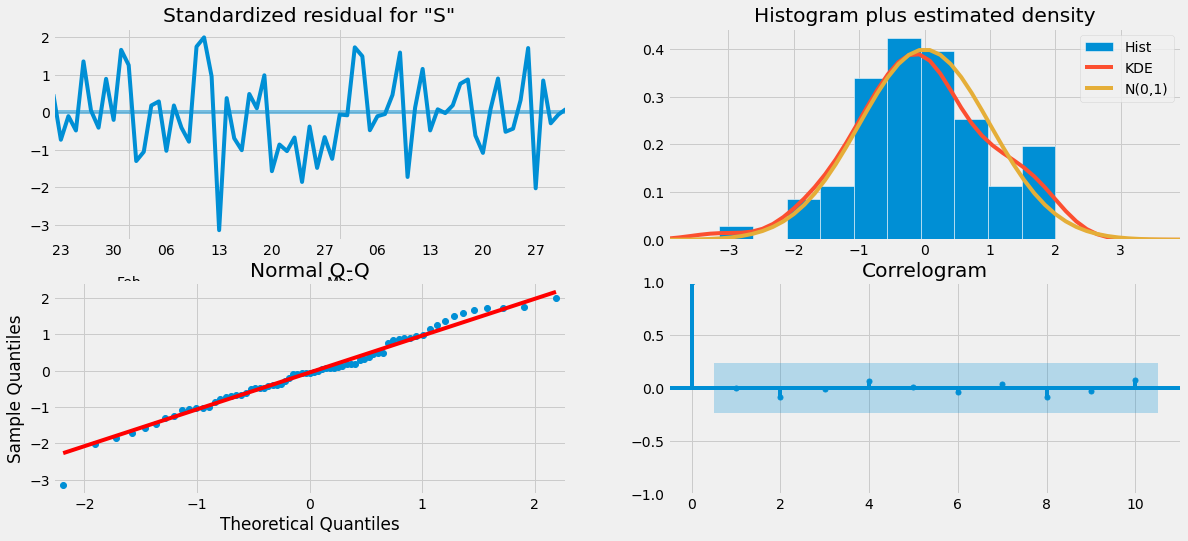

In [24]:
model_aic.plot_diagnostics(figsize=(18, 8))
plt.show()

##### Four plots result from the plot_diagnostics function. The Standardized residual, Histogram plus KDE estimate, Normal q-q, and the correlogram.


##### We can interpret the model as a good fit based on the following conditions.

##### 1). Standardized residual

There are no obvious patterns in the residuals, with values having a mean of zero and having a approximately uniform variance.

##### 2). Histogram plus KDE estimate

The KDE curve is very similar to the normal distribution (labeled as N(0,1) in the plot)

##### 3). Normal Q-Q

Most of the data points should lie on the straight line

##### 4). Correlogram (ACF plot)

95% of correlations for lag greater than zero should not be significant. The grey area is the confidence band, and if values fall outside of this then they are statistically significant. In our case, there are no any values outside of this area, therefore we do not need to add more predictors to make the model more accurate.

### Calculate the RMSE

In [25]:
predictions = model_aic.forecast(steps=len(y_test))

#calculate the Root Means Square Error
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
#Calculate Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(y_test, predictions)
print(f"The Root Mean Square Error of the forecast is {rmse}")
print(f"The Mean Absolute Percentage error of the forecast is {mape}")

The Root Mean Square Error of the forecast is 1387.9833385894908
The Mean Absolute Percentage error of the forecast is 0.15401562842060215


### Actual data vs Predictions

<AxesSubplot:xlabel='Date', ylabel='Sales'>

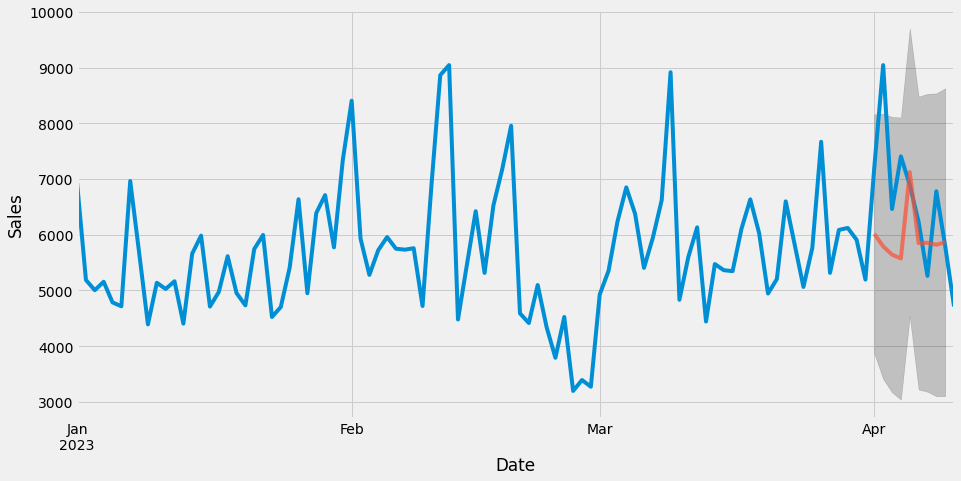

In [26]:
forecast = model_aic.get_forecast(steps = 9)

#predictions and confidence interval
predictions = forecast.predicted_mean
ci = forecast.conf_int()

#observed plot
fig = df['Sales Quantity'].plot(label = 'Observed', figsize = (14, 7))
fig.set_xlabel("Date")
fig.set_ylabel('Sales')
fig.fill_between(ci.index,
                ci.iloc[:, 0],
                ci.iloc[:, 1], color = 'k', alpha = 0.2)

#prediction plot
predictions.plot(ax = fig, label = 'Predictions', alpha = 0.7, figsize = (14, 7))

# Machine Learning Model

In [27]:
df_ml = df.copy()

### Splitting the data

In [28]:
train_ind = int(len(df) * 0.90)
train_data = df[:train_ind]
test_data = df[train_ind:]

##### In the classical time series model I removed the feature 'Discount Percentage' from the data set. But using the machine learning model we can observe the impact of the 'Discount Percentage' to the target varable. 

### Correlation of the data

                     Sales Quantity  Discount Percentage
Sales Quantity             1.000000             0.628254
Discount Percentage        0.628254             1.000000


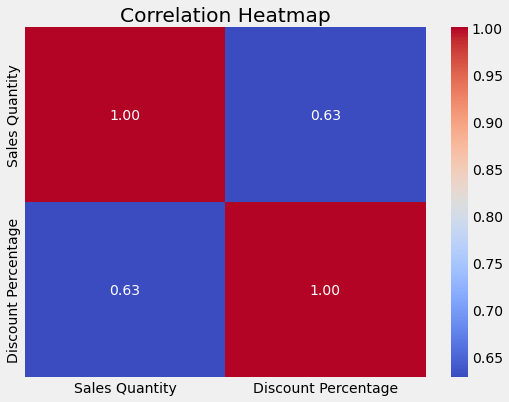

In [29]:
correlation_matrix = df.corr()
print(correlation_matrix)

# Create heatmap
plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Text(0, 0.5, 'Sales Quantity')

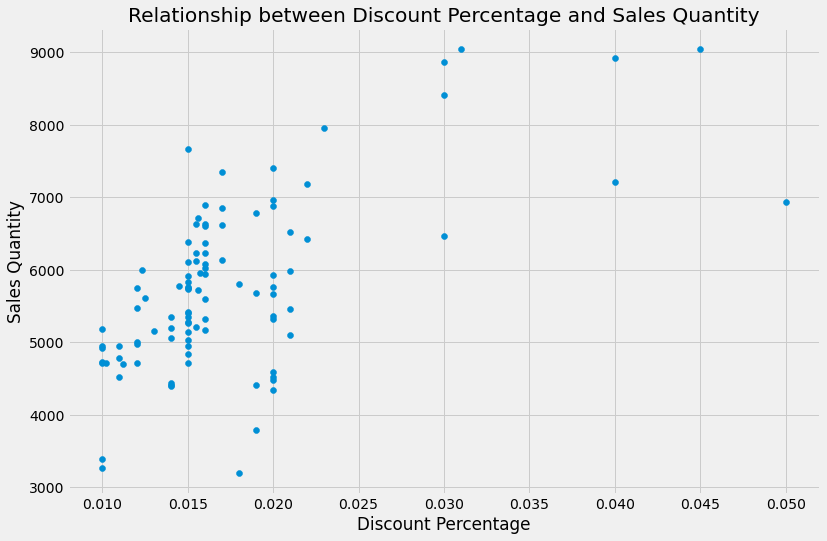

In [30]:
plt.figure(figsize=(12, 8))
plt.scatter(df_ml['Discount Percentage'],  df_ml['Sales Quantity'])
plt.title('Relationship between Discount Percentage and Sales Quantity')
plt.xlabel('Discount Percentage')
plt.ylabel('Sales Quantity')

##### According to the correlation, there is a moderate relationship between Discount percentage and the Sales Quantity

#### Visualize the data for month period

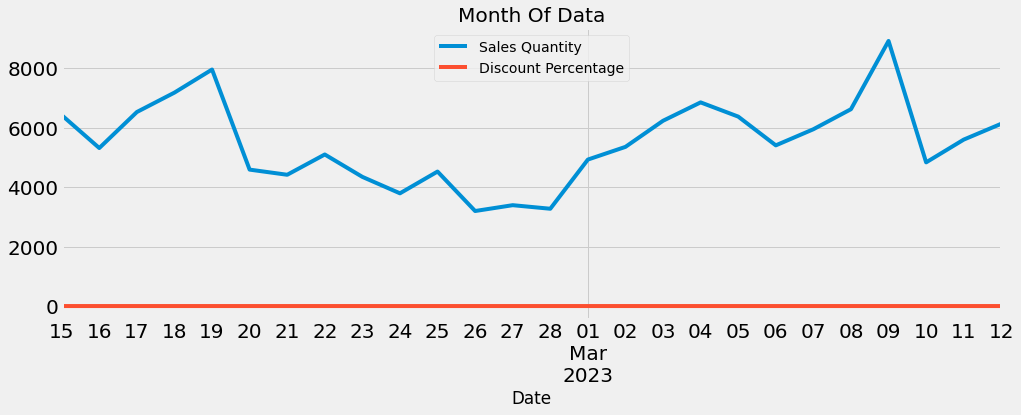

In [31]:
#visualize the data in one month period
df_ml.loc[(df_ml.index > '2023-02-14') & (df_ml.index < '2023-03-13')] \
    .plot(figsize=(15, 5), title='Month Of Data', fontsize = 20)
plt.show()

### Feature Creation

##### Since the machine learning model couldn't capture the date component of the data set, create new features related to the date.

In [32]:
def create_features(df):
    """
    Create time series features
    """
    df = df.copy()
    df['day_of_week'] = df.index.day_of_week
    df['month'] = df.index.month
    df['day_of_year'] = df.index.dayofyear
    df['day_of_month'] = df.index.day
    df['week_of_year'] = df.index.isocalendar().week

    return df

In [33]:
df_ml = create_features(df)

In [34]:
df_ml.head()

,Sales Quantity,Discount Percentage,day_of_week,month,day_of_year,day_of_month,week_of_year
Date,,,,,,,
2023-01-01,6934,0.050,6,1,1,1,52
2023-01-02,5187,0.010,0,1,2,2,1
2023-01-03,5004,0.012,1,1,3,3,1
2023-01-04,5155,0.013,2,1,4,4,1
2023-01-05,4785,0.011,3,1,5,5,1


### Visualize the features/ Target Relationship

#### Sales by month

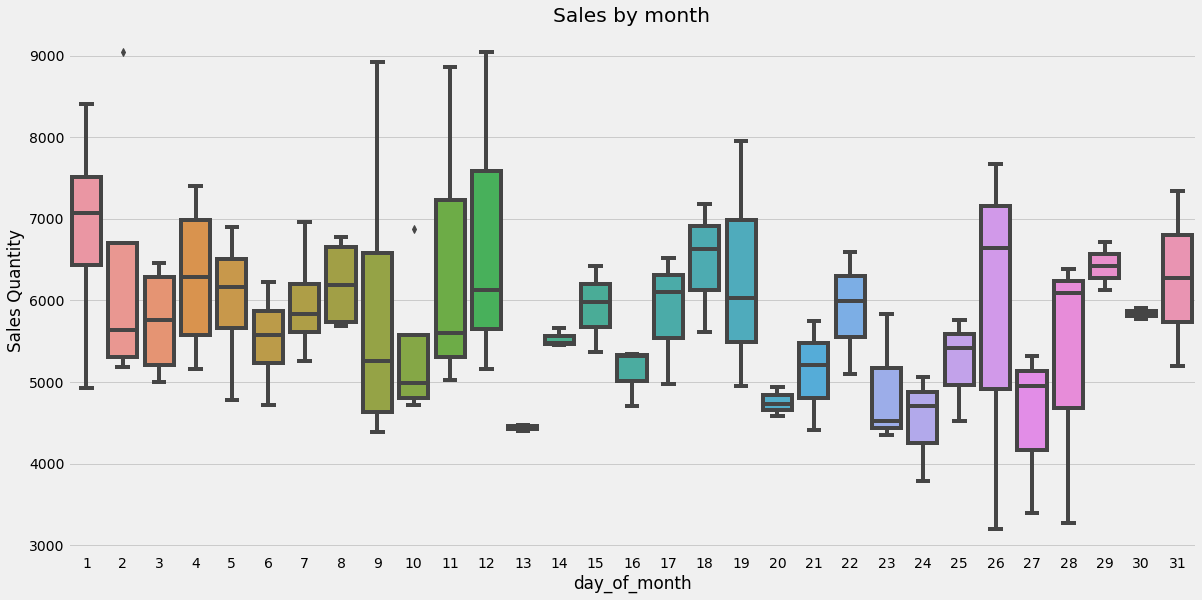

In [35]:
fig, ax = plt.subplots(figsize=(18, 9))
sns.boxplot(data = df_ml, x = 'day_of_month', y = 'Sales Quantity')
ax.set_title('Sales by month')
plt.show()

#### Sales by day of week

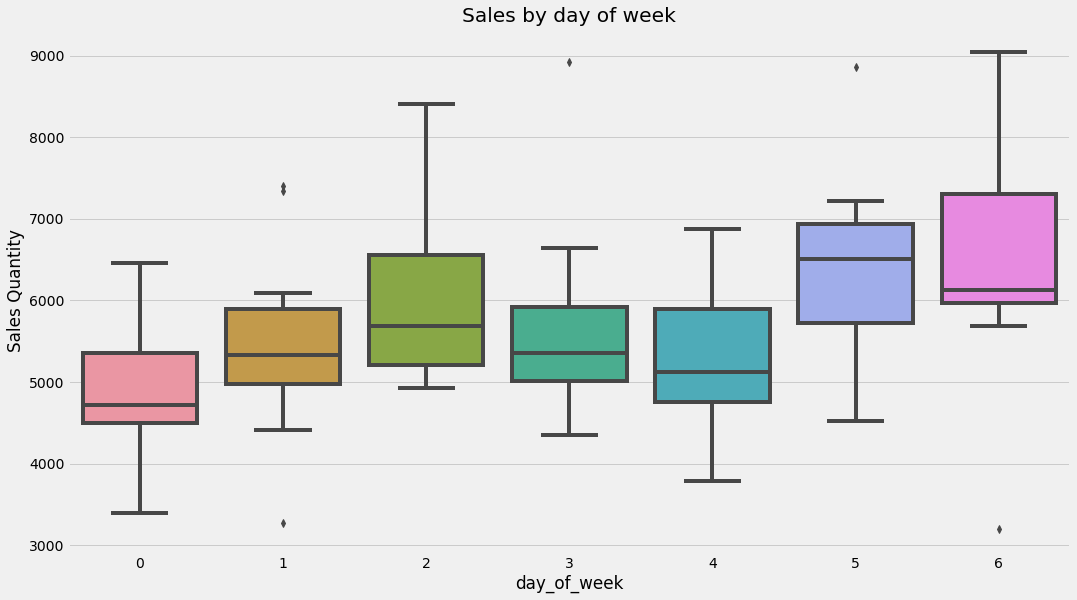

In [36]:
fig, ax = plt.subplots(figsize=(16, 9))
sns.boxplot(data = df_ml, x = 'day_of_week', y = 'Sales Quantity')
ax.set_title('Sales by day of week')
plt.show()

#### Adding features to train, test data sets

In [37]:
train_data = create_features(train_data)
test_data = create_features(test_data)

features = ['Discount Percentage', 'day_of_week', 'month','day_of_year', 'day_of_month', 'week_of_year']
target = 'Sales Quantity'

In [38]:
X_train = train_data[features]
y_train = train_data[target]

X_test = test_data[features]
y_test = test_data[target]

### Create the Machine Learning Model

### Random Forest

##### Random forests are an ensemble learning method, combining multiple decision trees. This can lead to more robust and accurate predictions, especially when there's a lot of variability or uncertainty in the data.

In [39]:
# Initialize the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [40]:
# Predict the sales for the testing data
predictions = rf.predict(X_test)

#calculate the Root Means Square Error
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)


#Calculate Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(y_test, predictions)

print('Root Mean Squared Error: {:.2f}'.format(rmse))
print('Mean Absolute Percentage Error: {:.2f}'.format(mape))

Root Mean Squared Error: 1031.40
Mean Absolute Percentage Error: 0.14


### Actual Data vs Predictions

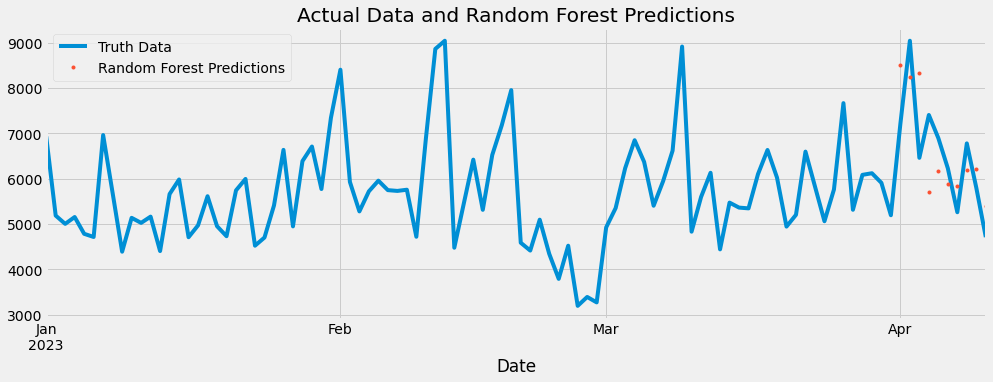

In [41]:
test_data['prediction'] = rf.predict(X_test)

# Merge the predictions with your original DataFrame
df_pred = df.merge(test_data[['prediction']], how='left', left_index=True, right_index=True)

# Plot the Sales Quantity and predictions
ax = df_pred['Sales Quantity'].plot(figsize=(15, 5))
df_pred['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Random Forest Predictions'])
ax.set_title('Actual Data and Random Forest Predictions')
plt.show()

### Hyper parameter tuning

In [42]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
max_depth.append(None)

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}
print(random_grid)

{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]}


In [46]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, verbose=2, random_state = 42)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END .......................max_depth=8, n_estimators=90; total time=   0.1s
[CV] END .......................max_depth=8, n_estimators=90; total time=   0.1s
[CV] END .......................max_depth=8, n_estimators=90; total time=   0.0s
[CV] END .......................max_depth=8, n_estimators=90; total time=   0.1s
[CV] END .......................max_depth=8, n_estimators=90; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=2, n_estimators=10; total time=   0.0s
[CV] END .......................max_depth=1, n_estimators=50; total time=   0.0s
[CV] END .......................max_depth=1, n

RandomizedSearchCV(estimator=RandomForestRegressor(), n_iter=100,
                   param_distributions={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, None],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100]},
                   random_state=42, verbose=2)

In [48]:
rf_random.best_params_

{'n_estimators': 10, 'max_depth': 2}

In [49]:
# Predict the sales for the testing data
predictions_random = rf_random.predict(X_test)

#calculate the Root Means Square Error
mse = mean_squared_error(y_test, predictions_random)
rmse = np.sqrt(mse)
print('Root Mean Squared Error: {:.2f}'.format(rmse))

Root Mean Squared Error: 1055.78


##### After parameter tuning for the random forest model I got Root Mean Squared Error value as 1055.78.

### XGBoost model

##### Seasonality and trends in time-series data are easily handled by XGBoost. Short-term upward or downward trends can be captured by trend features in the model, while periodic patterns can be captured by seasonal features. XGBoost predicts more accurately by taking trends and seasonality into account.

In [50]:
reg = xgb.XGBRegressor(booster='gbtree',    
                       n_estimators=1000,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:1125.45283	validation_1-rmse:1463.81638
[100]	validation_0-rmse:764.49662	validation_1-rmse:1075.51943
[200]	validation_0-rmse:580.89478	validation_1-rmse:1000.15260
[300]	validation_0-rmse:460.80056	validation_1-rmse:976.74934
[400]	validation_0-rmse:361.78234	validation_1-rmse:962.01829
[500]	validation_0-rmse:295.14263	validation_1-rmse:982.75984
[600]	validation_0-rmse:252.49458	validation_1-rmse:980.28041
[700]	validation_0-rmse:221.85611	validation_1-rmse:973.85855
[800]	validation_0-rmse:198.30105	validation_1-rmse:971.97964
[900]	validation_0-rmse:180.16567	validation_1-rmse:972.28546
[999]	validation_0-rmse:166.05907	validation_1-rmse:973.35254


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

##### Create XGBoost base model with the parameters:
    booster='gbtree',    
    n_estimators=1000,
    objective='reg:linear',
    max_depth=3,
    learning_rate=0.01

### Feature Importance

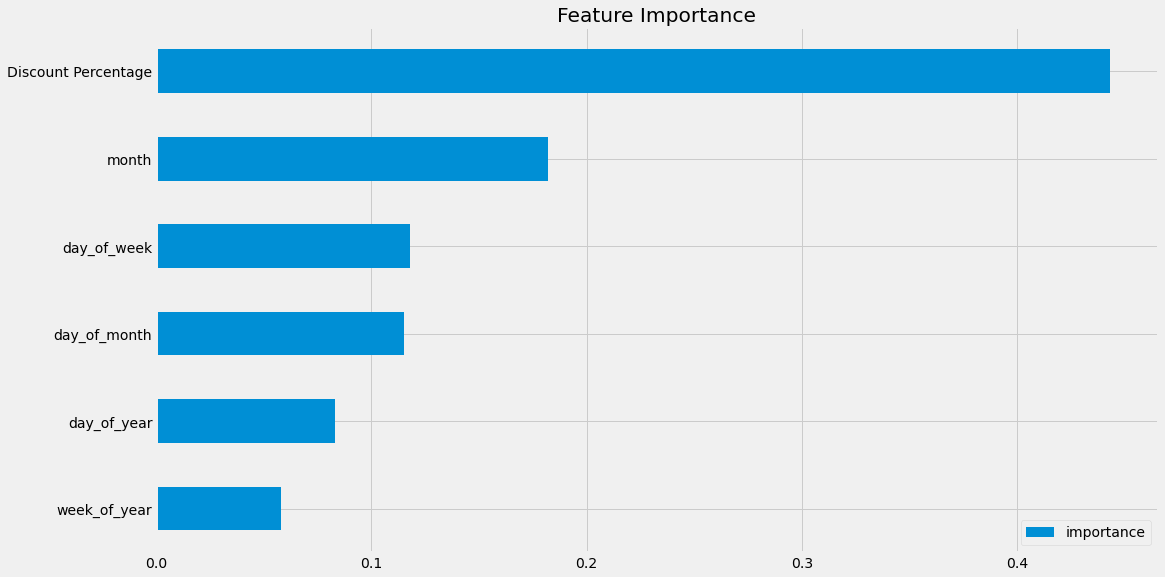

In [51]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

### Forecast on Test

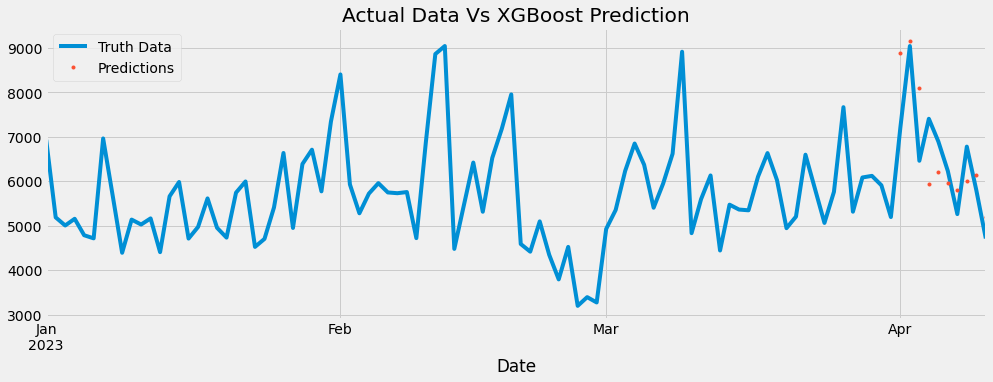

In [52]:
test_data['prediction'] = reg.predict(X_test)
df = df.merge(test_data[['prediction']], how='left', left_index=True, right_index=True)
ax = df['Sales Quantity'].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Actual Data Vs XGBoost Prediction')
plt.show()

In [53]:
#calculate the Root Means Square Error
mse = mean_squared_error(y_test, test_data['prediction'])
rmse = np.sqrt(mse)

#Calculate Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(y_test, predictions)

print('Root Mean Squared Error: {:.2f}'.format(rmse))
print('Mean Absolute Percentage Error: {:.2f}'.format(mape))

Root Mean Squared Error: 973.35
Mean Absolute Percentage Error: 0.14


##### Using XGBoost machine learning model I got Root Mean Squared Error value as 973.35.

### Hyper parameter Tuning

##### To achieve more effective model change the hyper parameters of the algorithm.

In [54]:
# Number of trees in XGBoost
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]

# Maximum depth of each tree in XGBoost
max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
max_depth.append(None)

# Learning rate
learning_rate = [0.01, 0.05, 0.1, 0.3, 0.5]

In [55]:
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'learning_rate': learning_rate}

print(random_grid)

# Use the random grid to search for best hyperparameters
xgb_model = xgb.XGBRegressor()

xgb_random = RandomizedSearchCV(estimator = xgb_model, param_distributions = random_grid, n_iter = 100, verbose=2, random_state = 42)
# Fit the random search model
xgb_random.fit(X_train, y_train)

{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None], 'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.5]}
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END ...learning_rate=0.05, max_depth=9, n_estimators=60; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=9, n_estimators=60; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=9, n_estimators=60; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=9, n_estimators=60; total time=   0.0s
[CV] END ...learning_rate=0.05, max_depth=9, n_estimators=60; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=8, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=8, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=8, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=8, n_estimators=100; total time=   0.0s
[CV] END ..learning_rate=0.01, max_depth=8, n_esti

RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,...
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                

In [56]:
best_params = xgb_random.best_params_

reg_random = xgb.XGBRegressor(booster='gbtree',
                       n_estimators=best_params['n_estimators'],
                       objective='reg:linear',
                       max_depth=best_params['max_depth'],
                       learning_rate=best_params['learning_rate'])

reg_random.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)


[0]	validation_0-rmse:1111.40986	validation_1-rmse:1436.15369
[79]	validation_0-rmse:726.78335	validation_1-rmse:972.50211


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=1, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=80, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [57]:
# Predict using the model trained with best hyperparameters
predictions_random = reg_random.predict(X_test)

# Calculate Root Mean Squared Error
mse = mean_squared_error(y_test, predictions_random)
rmse = np.sqrt(mse)

# Calculate Mean Absolute Percentage Error
mape = mean_absolute_percentage_error(y_test, predictions_random)

print('Root Mean Squared Error: {:.2f}'.format(rmse))
print('Mean Absolute Percentage Error: {:.2f}'.format(mape))


Root Mean Squared Error: 972.50
Mean Absolute Percentage Error: 0.13


##### After parameter tuning I got Root Mean Squared Error as 972.50.

##### Compare to the Random Forest model with the XGBoost model, XGBoost model gives more perfect model then Random forest model. Therefor I compare the SARIMA model with XGBoost model.

## Comparison of Classical Time Series Model-SARIMA and Machine Learning Model-XGBoost

##### Classical time series model (SARIMA) RMSE - 1387.9833385894908, and MAPE  - 0.15401562842060215

##### XGBoost model  RMSE - 972.50 and MAPE - 0.13

##### Comapre to the XGBoost model and the SARIMA model we can cleary observe that the XGBoost  model is more effective than the SARIMA model in this case.

##### The lower RMSE obtained by the XGBoost model suggests that incorporating additional features, especially the Discount Percentage and date - related features, improved the model's predictive performance.

##### Including the Discount Percentage as a feature likely helped capture its influence on sales quantity, enabling the model to better understand the relationship between Discount Percentage and Sales Quantity.

##### Introducing date-related features provided the model with more contextual information, allowing it to capture potential seasonality or trends in the data that could influence Sales Quantiy.